In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'train_losses', 'valid_losses', 'train_acc', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [3]:
def read_transformer_results(root_dir, exp_dir):
    args = exp_dir.split('_')[3:]
    df = summarize(os.path.join(root_dir, exp_dir), 'trial_results.csv', 'chan_avg_transformer')

    df = df.assign(n_layers=int(args[0].split('-')[0]))
    df = df.assign(d_model=int(args[1].split('-')[0]))
    df = df.assign(n_heads=int(args[2].split('-')[0]))
    df = df.assign(factor=int(args[3].split('-')[0]))
    
    return df

In [4]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'chan_avg_transformer', 'rs',
                        'bandpass_only', 'max_abs_scale', 'baseline')
for d in os.listdir(root_dir):
    try:
        df = read_transformer_results(root_dir, d)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError:
        pass
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [5]:
all_model_df.columns

Index(['Status', 'epoch_early_stop', 'final_test_loss', 'montage', 'subject',
       'test_accuracy', 'test_auc', 'test_f1', 'test_precision', 'test_recall',
       'train_acc', 'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_acc', 'valid_accuracy',
       'valid_auc', 'valid_f1', 'valid_loss', 'valid_losses',
       'valid_precision', 'valid_recall', 'epochs', 'final_train_loss',
       'approach', 'n_layers', 'd_model', 'n_heads', 'factor'],
      dtype='object')

In [29]:
n_layers = 3
n_heads = 8
factor = 5
d_model = 128

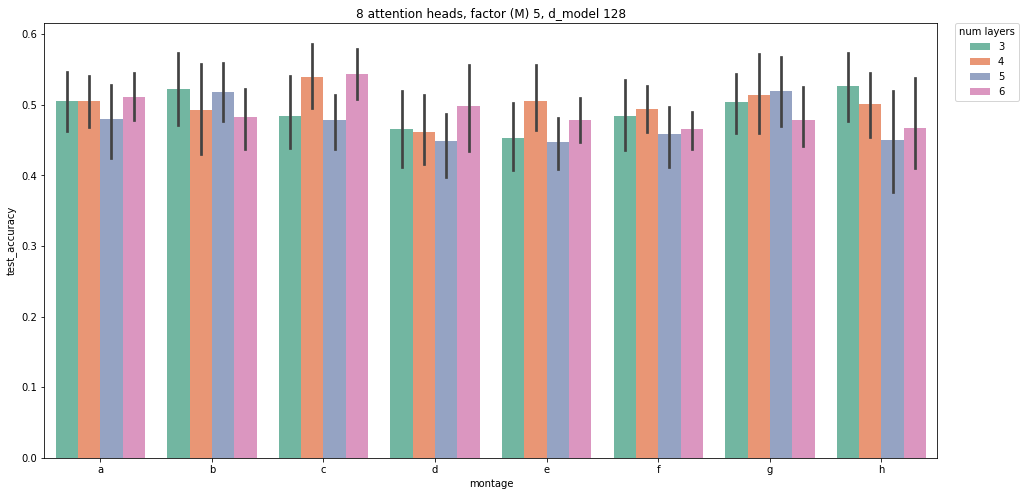

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['n_heads'] == n_heads) & 
                              (all_model_df['factor'] == factor) & 
                              (all_model_df['d_model'] == d_model)],
            x='montage', y='test_accuracy', hue='n_layers', palette='Set2', ax=ax, order=constants.MONTAGES)
plt.legend(title='num layers', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'{n_heads} attention heads, factor (M) {factor}, d_model {d_model}');

In [20]:
output_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model)].groupby('montage').mean()
output_df[test_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,
a,0.489,0.503,0.384,0.381,0.643,0.641,0.666,0.650,143.733
b,0.508,0.494,0.501,0.482,0.657,0.657,0.633,0.641,145.667
c,0.499,0.526,0.473,0.452,0.642,0.642,0.639,0.638,144.267
d,0.519,0.503,0.463,0.442,0.656,0.657,0.670,0.661,153.933
e,0.527,0.530,0.517,0.499,0.624,0.636,0.611,0.616,132.333
f,0.503,0.538,0.431,0.422,0.679,0.684,0.663,0.672,154.800
g,0.514,0.557,0.510,0.475,0.666,0.670,0.676,0.671,135.067
h,0.489,0.535,0.538,0.480,0.671,0.678,0.680,0.676,153.000


In [26]:
output_df = output_df[['hidden_size', 'rnn_layers', 'fc_layers',] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'Hidden Size', 'RNN Layers', 'FC Layers', 'Accuracy', 'Precision', 'Recall', 'F1']))

KeyError: "['rnn_layers', 'hidden_size', 'fc_layers'] not in index"

## Train/Valid Losses

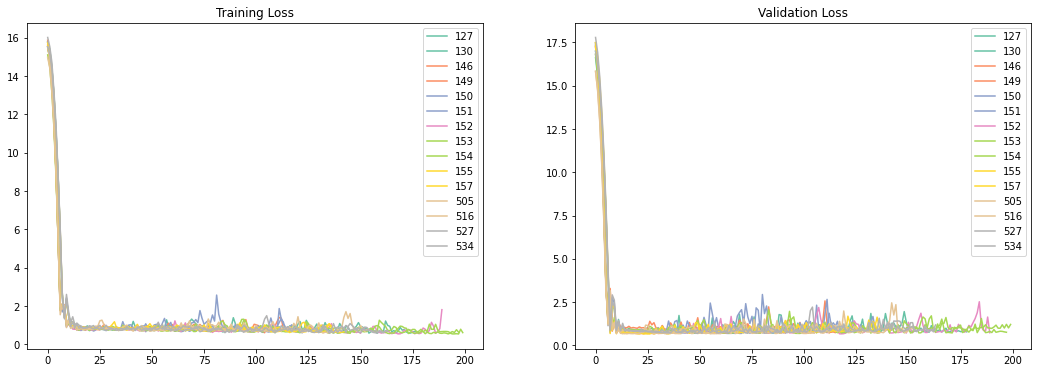

In [31]:
n_layers = 5
n_heads = 2
factor = 5
d_model = 64
montage = 'e'

subset_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())

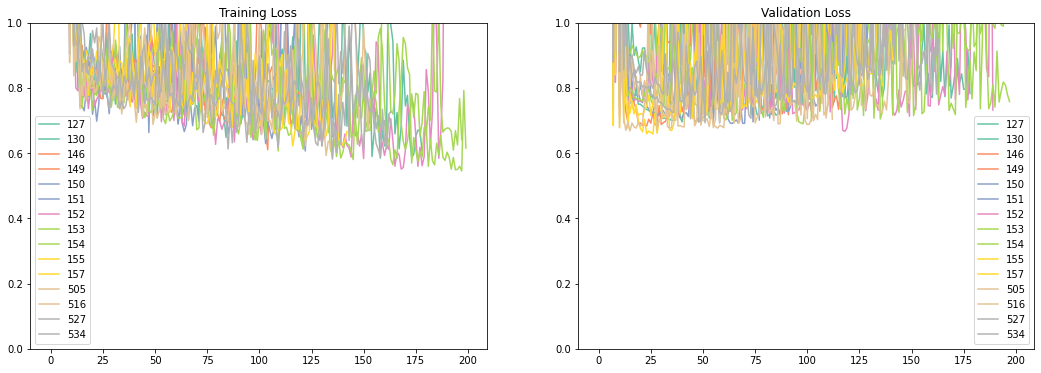

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    ax[0].set_ylim((0, 1))
    ax[1].set_ylim((0, 1))
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracies

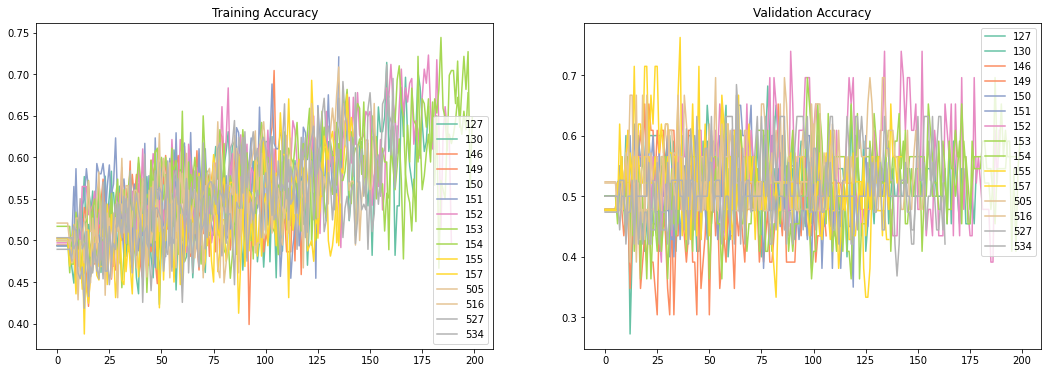

In [33]:
# n_layers = 5
# n_heads = 4
# factor = 5
# d_model = 64
# montage = 'e'

subset_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())